# Code for Section 6: Trees and Forests

This notebook is split into two distinct portions: training and analysis. Training saves all the data required for analysis.
This means that the two parts do not need to be run during the same Jupyter session.

This notebook generates Figure 15 from https://arxiv.org/abs/2301.03962v1


In [1]:
# PARAMETERS THAT NEED TO BE SET IN BOTH PARTS
N_TRIALS = 100
DATASET_NAME = "mnist"




## Setting up variables

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from decompose.data_utils import load_standard_dataset, load_data
from decompose import BVDExperiment

# Because these experiments take longer to run, we now use logging to keep track of them,
# so we can continue to monitor progress even after disconnection
import logging

# Check that directories exist for experiment results/data/logs
if not os.path.exists("images"):
    os.mkdir("images")
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("logs"):
    os.mkdir("logs")
if not os.path.exists("decomposition_objects"):
    os.mkdir("decomposition_objects")

logger = logging.getLogger()
logger_filename = time.strftime("%y_%m_%d_%H_%M_%S")
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                    filename=f"logs/section4_trees_{logger_filename}.log",
                    datefmt="%Y/%m/%d %H:%M:%S")
for logger_name in logging.root.manager.loggerDict:
    logging.getLogger(logger_name).setLevel(logging.CRITICAL)
logging.getLogger("decompose.experiments").setLevel(logging.DEBUG)
logging.debug("New Notebook Started")
stream_handler = logging.StreamHandler

# Models are combined using the geometric bagging classifier. This is not part of the library proper
# so is imported using a relative import.
import sys
sys.path.append("../models/")
from bagging_ensembles import GeometricBaggingClassifier


In [3]:

# Set up data and parameters

np.random.seed(0)
# For mnist, we use the default split on the data
frac_training = None if DATASET_NAME == "mnist" else 0.75

train_data, train_labels, test_data, test_labels = load_standard_dataset(DATASET_NAME, frac_training=frac_training)
PARAMETER_NAME = "n_estimators"
PARAMETER_VALUES = range(1, 21, 1)

# Set up models
results_objects = {}

constrained_bagging = GeometricBaggingClassifier(
                                                 base_estimator=DecisionTreeClassifier(max_depth=5),
                                                 warm_start=True,
                                                 smoothing_factor=1e-9)

unconstrained_bagging = GeometricBaggingClassifier(
                                      base_estimator=DecisionTreeClassifier(),
                                      warm_start=True,
                                      smoothing_factor=1e-9)

random_forest = GeometricBaggingClassifier(
                                      base_estimator=DecisionTreeClassifier(max_features='sqrt'),
                                      warm_start=True,
                                      smoothing_factor=1e-9)

models = {"Bagging (max depth 5)": constrained_bagging,
          "Bagging (unconstrained)": unconstrained_bagging,
          "Random Forest": random_forest }



# Part A: Training

## Training the Models

In [ ]:
for name, model in models.items():
    np.random.seed(0)
    # Create experiment object and define parameter to vary
    experiment = BVDExperiment(model,
                               "cross_entropy",
                               parameter_name=PARAMETER_NAME,
                               parameter_values=PARAMETER_VALUES,
                               save_decompositions=True,
                               per_trial_test_error=True,
                               decompositions_prefix=f"decomposition_objects/{name}_v2")
    # Run experiment on data
    results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=2)
    results_objects[name] = results
    results.save_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_v2.pkl")

 65%|██████▌   | 13/20 [5:09:45<3:07:54, 1610.61s/it]

In [17]:
# We also a train a single tree model in order to get the test error

decision_tree = DecisionTreeClassifier(max_depth=5)
np.random.seed(0)

# Create experiment object and define parameter to vary
experiment = BVDExperiment(decision_tree,
                           loss="cross_entropy")

# Run experiment on data
results = experiment.run_experiment(train_data, train_labels, test_data, test_labels, n_trials=N_TRIALS, n_test_splits=2)
results_objects[name] = results

results.save_results(f"data/Fig4_decision_tree_{DATASET_NAME}_results_{N_TRIALS}.pkl")

print('Cross-entropy (validation,test) ', results.ensemble_risk)

print('0-1 loss (test) ' , results.test_error[:,1])

Cross-entropy (validation,test)  [[1.06613359 1.09575896]]
0-1 loss (test)  [0.32794]


# Part B: Analysis

## Set up for Analysis

In [4]:

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from tqdm import tqdm
from functools import partial
import numpy as np

from decompose.experiments import load_results

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

models = ["Bagging (max depth 5)",
          "Bagging (unconstrained)",
          "Random Forest"]


# Load results objects from experiment
results_objects = {}
for name in models:
    results_objects[name] = load_results(f"data/Fig4_{name}_{DATASET_NAME}_results_{N_TRIALS}_v2.pkl")

PARAMETER_VALUES = results_objects["Bagging (unconstrained)"].parameter_values

VAL_IDX = 0
TEST_IDX = 1


bag_results = results_objects["Bagging (unconstrained)"]
rf_results = results_objects["Random Forest"]


# Set up functions (with no arguments) to retrieve decomposition_objects from results
decomposition_objects = [partial(bag_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(rf_results.parameter_values))]
decomposition_objects += [partial(rf_results.get_decomposition_object, idx, TEST_IDX) for idx in range(len(rf_results.parameter_values))]

print("objects loaded")
diversities = np.concatenate([bag_results.diversity[:,VAL_IDX], rf_results.diversity[:,VAL_IDX]])


objects loaded


## Figure 14: Diversity Scatter Plots

In [5]:

ambiguities_list = []
ensemble_errors_list = []
average_individual_errors_list = []


for decomp_idx, decomp in enumerate(tqdm(decomposition_objects)):
    decomp = decomp()
    pred = decomp.pred
    labels = decomp.labels

    predicted_class = np.argmax(decomp.pred, axis=3)
    
    average_individual_errors = np.zeros((pred.shape[0]))

    for i in range(pred.shape[1]):
        for j in range(pred.shape[0]):
            average_individual_errors[j] += 1 / pred.shape[1] * zero_one_loss(labels, predicted_class[j, i, :])
    average_individual_errors_list.append(average_individual_errors)
    # Stuff for ensemble error
    ensemble_errors = np.zeros((pred.shape[0]))
    ensemble_preds = decomp._inverse_generator_gradient(
                                        decomp.etas.mean(axis=1, keepdims=False))
    
    ensemble_predicted_class = np.argmax(ensemble_preds, axis=2)
    for j in range(pred.shape[0]):
        ensemble_errors[j] = zero_one_loss(labels, ensemble_predicted_class[j, :])
    ensemble_errors_list.append(ensemble_errors)



100%|██████████| 40/40 [03:10<00:00,  4.76s/it]


Bagging R^2 0.9966102158287015
RF R^2 0.9982925669075523


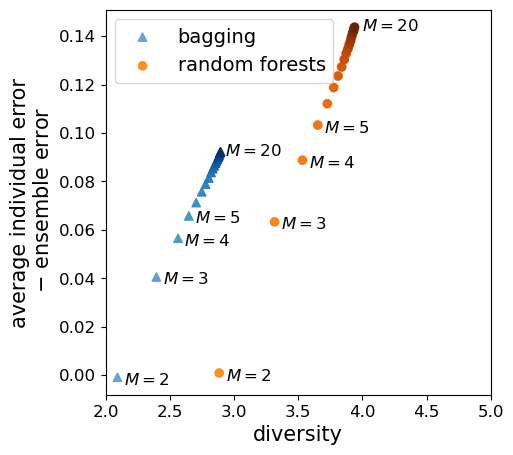

In [6]:
x = np.array(diversities)
y = np.zeros_like(diversities)
import matplotlib.ticker as plticker
from scipy.stats import pearsonr


for idx in range(len(diversities)):
    y[idx] = (average_individual_errors_list[idx] - ensemble_errors_list[idx]).mean()


matplotlib.rc('xtick', labelsize=11)
matplotlib.rc('ytick', labelsize=11)


# fig, ax = plt.subplots(figsize=(8,4))
fig, ax = plt.subplots(figsize=(5, 5))

bagging_coeff = (np.corrcoef(x[1:20], y[1:20])**2)[0,1]
print(f"Bagging R^2 {bagging_coeff}")
rf_coeff = (np.corrcoef(x[21:40], y[21:40])**2)[0,1]
print(f"RF R^2 {rf_coeff}")

ax.scatter(x[1:20], y[1:20], c=range(21,40), label="bagging", cmap="Blues", marker="^", vmin=1)
ax.scatter(x[21:], y[21:], c=range(21,40), label="random forests", cmap="YlOrBr", vmin=1)
ax.set_xlabel("diversity", fontsize=15)
ax.set_ylabel("average individual error\n $-$ ensemble error", fontsize=15)
ax.legend(prop = {"size" : 14})
#FONTSIZE = 12
FONTSIZE=12

for idx in [1, 2, 3, 4]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.05, y[idx] - 0.003 ), fontsize=FONTSIZE)
    ax.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.05, y[idx + 20] - 0.003), fontsize=FONTSIZE )
    
for idx in [19]:
    ax.annotate(f"$M={idx + 1}$", (x[idx] + 0.035, y[idx] - 0.0015 ), fontsize=FONTSIZE)
    ax.annotate(f"$M={idx + 1}$", (x[idx + 20] + 0.055, y[idx + 20] - 0.0015 ), fontsize=FONTSIZE)
    

loc = plticker.MultipleLocator(base=.5)
ax.xaxis.set_major_locator(loc)
ax.tick_params(axis="x", labelsize= 12)
ax.tick_params(axis="y", labelsize= 12)
ax.set_xlim(right=5)
ax.set_box_aspect(1)

plt.savefig(f"images/scatter_diversity_{DATASET_NAME}_{N_TRIALS}_trees_v2.pdf",  bbox_inches="tight")

